In [1]:
# 19/04/21

In [2]:
import os
os.getcwd()

'/Users/tavoalcazar/Documents/CloudComputing/DrowsinessDetectionCode'

## Drowsiness Detection using Python

**References**:

    - https://www.youtube.com/watch?v=qwUIFKi4V48
    - http://mrl.cs.vsb.cz/eyedataset

In [3]:
import tensorflow as tf   ## pip install tensorflow-gpu
import cv2                ## pip install opencv-python
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
print(tf.__version__)       # TF version
print(tf.keras.__version__) # Keras version

2.4.0-dev20201019
2.4.0


From Eye Dataset, let's take around 60 images per person (30 with closed eyes and 30 with open eyes) so that we can collect a Testset of around 2,220 images. Original Dataset contains 54,000 images.

At the end, we collected 1,000 images for Closed Eyes and another 1,000 for Open Eyes, so a total of 2,000 images for training our model.

In [6]:
img_array = cv2.imread('Test_Dataset/Closed_Eyes/s0001_00001_0_0_0_0_0_01.png', cv2.IMREAD_GRAYSCALE)

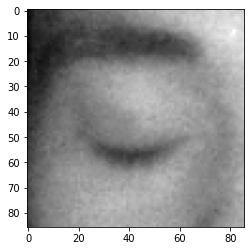

In [7]:
plt.imshow(img_array, cmap='gray')

In [8]:
img_array.shape

(86, 86)

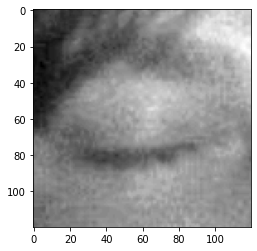

In [9]:
Datadirectory = 'Test_Dataset/' # training dataset
Classes = ['Closed_Eyes', 'Open_Eyes'] # list of classes
for category in Classes:
    path = os.path.join(Datadirectory, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        backtorgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
        plt.imshow(img_array, cmap='gray')
        plt.show()
        break
    break

(224, 224, 3)


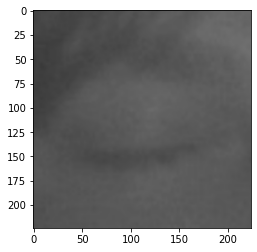

In [11]:
img_size = 224

new_array = cv2.resize(backtorgb, (img_size, img_size))
print(new_array.shape)
plt.imshow(new_array, cmap='gray')
plt.show()

### Reading all the images and converting them into an array for data and labels

In [12]:
training_Data = []

def create_training_Data():
    for category in Classes:
        path = os.path.join(Datadirectory, category)
        class_num = Classes.index(category) # 0 or 1
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                backtorgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
                new_array = cv2.resize(backtorgb, (img_size, img_size))
                training_Data.append([new_array, class_num])
            except Exception as e:
                pass

In [13]:
create_training_Data()

In [14]:
print(len(training_Data))

1998


In [15]:
import random

random.shuffle(training_Data)

In [17]:
X = []
y = []

for features, label in training_Data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, img_size, img_size, 3)

In [18]:
X.shape

(1998, 224, 224, 3)

In [19]:
# normalize the data
X = X / 255.0 

In [20]:
Y = np.array(y)

In [21]:
import pickle

pickle_out = open('X.pickle', 'wb')
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open('y.pickle', 'wb')
pickle.dump(y, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open('X.pickle', 'rb')
X = pickle.load(pickle_in)

pickle_in = open('y.pickle', 'rb')
y = pickle.load(pickle_in)

### Deep Learning Model for training - Transfer Learning

In [22]:
from tensorflow import keras
from tensorflow.keras import layers

In [23]:
model = tf.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 6s 0us/step


In [24]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

### Transfer Learning

In [25]:
base_input = model.layers[0].input  # input layer

In [26]:
base_output = model.layers[-4].output  # we discard last three layers of MobileNet model

In [27]:
base_input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [28]:
base_output

<KerasTensor: shape=(None, 1, 1, 1024) dtype=float32 (created by layer 'dropout')>

In [29]:
flat_layer = layers.Flatten()(base_output)
final_output = layers.Dense(1)(flat_layer) # one node (1 / 0)
final_output = layers.Activation('sigmoid')(final_output)

In [30]:
new_model = keras.Model(inputs = base_input, outputs = final_output)

In [ ]:
# In case we want to freeze layers
for layer in model.layers:
    layer.trainable = False

In [31]:
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

### Setting for binary classification (open / closed)

In [32]:
new_model.compile(loss = 'binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])

In [34]:
len(X)

1998

In [44]:
len(Y)

1998

In [45]:
Y[305]

1

In [46]:
new_model.fit(X, Y, epochs = 1, validation_split = 0.1)  # training

57/57 [==============================] - 216s 4s/step - loss: 0.3024 - accuracy: 0.8807 - val_loss: 7.8487 - val_accuracy: 0.5000


In [47]:
new_model.save('my_model_1_epoch.h5')

In [48]:
improved_new_model = keras.Model(inputs = base_input, outputs = final_output)
improved_new_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

In [49]:
improved_new_model.compile(loss = 'binary_crossentropy',
                           optimizer = 'adam',
                           metrics = ['accuracy'])

improved_new_model.fit(X, Y, epochs = 10, validation_split = 0.1)  # training

Epoch 1/10
57/57 [==============================] - 168s 3s/step - loss: 0.0808 - accuracy: 0.9746 - val_loss: 0.8695 - val_accuracy: 0.8800
Epoch 2/10
57/57 [==============================] - 158s 3s/step - loss: 0.0379 - accuracy: 0.9905 - val_loss: 0.1980 - val_accuracy: 0.9200
Epoch 3/10
57/57 [==============================] - 159s 3s/step - loss: 0.0085 - accuracy: 0.9989 - val_loss: 0.3470 - val_accuracy: 0.9100
Epoch 4/10
57/57 [==============================] - 157s 3s/step - loss: 0.0063 - accuracy: 0.9991 - val_loss: 0.3766 - val_accuracy: 0.9200
Epoch 5/10
57/57 [==============================] - 154s 3s/step - loss: 0.0044 - accuracy: 0.9977 - val_loss: 0.0683 - val_accuracy: 0.9850
Epoch 6/10
57/57 [==============================] - 154s 3s/step - loss: 0.0106 - accuracy: 0.9970 - val_loss: 0.7018 - val_accuracy: 0.8850
Epoch 7/10
57/57 [==============================] - 156s 3s/step - loss: 0.0167 - accuracy: 0.9965 - val_loss: 0.4055 - val_accuracy: 0.9600
Epoch 8/10
57

In [50]:
improved_new_model.save('my_model_10_epochs.h5')

In [ ]:
#new_model = tf.keras.models.load_model('my_model_Drowsiness.h5')

### Checking the network for predictions

**Predict for a closed eyes image :**

In [102]:
img_array = cv2.imread('mrlEyes_2018_01/s0001/s0001_00155_0_0_0_0_0_01.png', cv2.IMREAD_GRAYSCALE)
backtorgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
new_array = cv2.resize(backtorgb, (img_size, img_size))

In [103]:
X_input = np.array(new_array).reshape(1, img_size, img_size, 3)

In [104]:
X_input.shape

(1, 224, 224, 3)

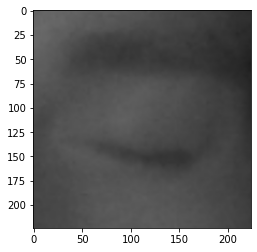

In [105]:
plt.imshow(new_array)

In [106]:
X_input = X_input / 255.0

In [107]:
prediction = improved_new_model.predict(X_input)

In [108]:
prediction

array([[3.1239837e-05]], dtype=float32)

**Predict for an open eyes image :**

In [66]:
img_array = cv2.imread('mrlEyes_2018_01/s0012/s0012_08255_0_0_1_1_0_02.png', cv2.IMREAD_GRAYSCALE)
backtorgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
new_array = cv2.resize(backtorgb, (img_size, img_size))

X_input = np.array(new_array).reshape(1, img_size, img_size, 3)
X_input = X_input / 255.0
print(X_input.shape)

(1, 224, 224, 3)


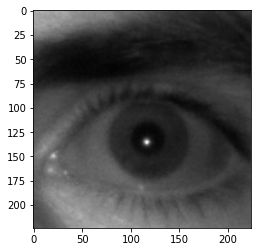

In [67]:
plt.imshow(new_array)

In [68]:
prediction = new_model.predict(X_input)
prediction

array([[0.9999629]], dtype=float32)

### Let's check on unknown images

For any normal face image, we will need to crop the eyes in order for the DL model to classify it as closed or open eyes. Therefore we'll make use of the **HAAR CASCADE FACE DETECTION** xml files.

Go to the following link:

    - https://github.com/opencv/opencv/tree/master/data/haarcascades

In [71]:
img = cv2.imread('woman_1.jpeg')

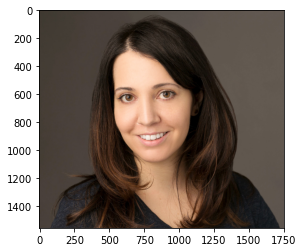

In [72]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [73]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [77]:
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

In [78]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [79]:
eyes = eye_cascade.detectMultiScale(gray, 1.1, 4) # detect multiple eyes

In [82]:
eyes

array([[813, 523, 165, 165],
       [552, 551, 150, 150]], dtype=int32)

In [83]:
for(x, y, w, h) in eyes:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

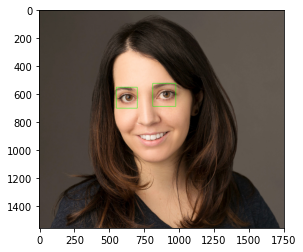

In [84]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Cropping the Eye image

In [85]:
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

eyes = eye_cascade.detectMultiScale(gray, 1.1, 4)
for (x, y, w, h) in eyes:
    # roi - region of interest
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyess = eye_cascade.detectMultiScale(roi_gray)
    if len(eyess) == 0:
        print('Eyes are not being detected')
    else:
        for (ex, ey, ew, eh) in eyess:
            eyes_roi = roi_color[ey:ey+eh, ex:ex+ew]

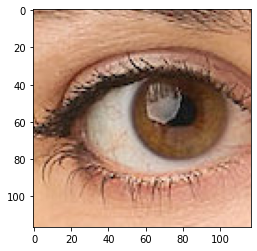

In [86]:
plt.imshow(cv2.cvtColor(eyes_roi, cv2.COLOR_BGR2RGB))

In [87]:
eyes_roi.shape

(117, 117, 3)

In [88]:
final_image = cv2.resize(eyes_roi, (224, 224))
final_image = np.expand_dims(final_image, axis = 0) # need a fourth dimension
final_image = final_image / 255.0

In [89]:
final_image.shape

(1, 224, 224, 3)

In [90]:
new_model.predict(final_image)

array([[0.9536096]], dtype=float32)

In [92]:
improved_new_model.predict(final_image)

array([[0.9536096]], dtype=float32)

In [91]:
####

## Realtime Video Demo

### First detect that eyes are closed or open

In [111]:
import cv2

path = 'haarcascade_frontalface_default.xml'
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(1)

# check if webcam is opened correctly
if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError('Cannot open webcam')
    
while True:
    ret, frame = cap.read()
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # print(faceCascade.empty())
    eyes = eye_cascade.detectMultiScale(gray, 1.1, 4)
    for (x, y, w, h) in eyes:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        eyess = eye_cascade.detectMultiScale(roi_gray)
        if len(eyess) == 0:
            print('Eyes are not being detected')
        else:
            for (ex, ey, ew, eh) in eyess:
                eyes_roi = roi_color[ey:ey+eh, ex:ex+ew]
                
    final_image = cv2.resize(eyes_roi, (224, 224))
    final_image = np.expand_dims(final_image, axis = 0) # need a fourth dimension
    final_image = final_image / 255.0
    
    #Predictions = new_model.predict(final_image)
    Predictions = improved_new_model.predict(final_image)
    if (Predictions > 0.5):
        status = 'Open Eyes'
    else:
        status = 'Closed Eyes'
        
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    print(faceCascade.empty())
    faces = faceCascade.detectMultiScale(gray, 1.1, 4)
    
    # Draw a rectangle around the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    # Use putText() method for inserting text on video
    cv2.putText(frame,
                status,
                (50, 50),
                font, 3,
                (0, 0, 255), # red color (BGR)
                2,
                cv2.LINE_4)
    cv2.imshow('Drowsiness Detection Tutorial', frame)
    
    if cv2.waitKey(2) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()  

False
Eyes are not being detected
False
Eyes are not being detected
False
Eyes are not being detected
False
Eyes are not being detected
False
Eyes are not being detected
False
Eyes are not being detected
False
False
Eyes are not being detected
False
Eyes are not being detected
False
False
False
False
False
False
Eyes are not being detected
False
Eyes are not being detected
False
False
Eyes are not being detected
False
False
Eyes are not being detected
False
False
False
Eyes are not being detected
False
Eyes are not being detected
False
Eyes are not being detected
False
False
Eyes are not being detected
False
False
False
Eyes are not being detected
False
False
False
Eyes are not being detected
Eyes are not being detected
False
False
False
False
False
Eyes are not being detected
False
False
False
Eyes are not being detected
False
False
False
False
Eyes are not being detected
False
False
Eyes are not being detected
Eyes are not being detected
False
Eyes are not being detected
False
Eyes a

False
False
Eyes are not being detected
False
False
False
False
False
False
Eyes are not being detected
False
False
False
False
False
Eyes are not being detected
False
False
False
False
Eyes are not being detected
False
False
False
Eyes are not being detected
False
False
False
Eyes are not being detected
False
False
Eyes are not being detected
False
False
False
False
False
False
False
False
False
Eyes are not being detected
False
False
False
False
False
False
False
False
False
False
Eyes are not being detected
False
False
False
False
False
Eyes are not being detected
False
False
Eyes are not being detected
False
False


KeyboardInterrupt: 

In [ ]:
#cap.release()

In [ ]:
#cv2.destroyAllWindows() 